# This jupyter notebook contains the code for Moho depths, cross-correlation matrix, robustness and figure 10

In [1]:
## importing the dependencies
# importing necessary dependencies.
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import obspy
import seaborn as sns
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import tsfel
import seaborn as sns

import matplotlib.cm as cm
from matplotlib.colors import Normalize  
from matplotlib import ticker


from scipy.interpolate import griddata as gd
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

from cartopy.io.img_tiles import Stamen
import pygmt

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
plt.style.use('default')

In [2]:
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'

In [3]:
### Checking the folders present in the data directory
files = glob('Data/*')

file = glob('Data/*')[2]
vs = glob(file + '/*')

PO_HB = pd.read_csv(files[4], header = None, sep=' ')
X5 = pd.read_csv(files[5], header = None, sep=' ')

### storing station names and coordinates 
stations = []
for i in range(len(vs)):
    stations.append(vs[i].split('/')[2].split('_')[1])
    
stn_db = pd.concat([PO_HB,X5])
stn_db.index = stn_db[2]

new_mod_lons = []
new_mod_lats = []

for i in range(len(stations)):
    new_mod_lons.append(stn_db.at[stations[i],0])
    new_mod_lats.append(stn_db.at[stations[i],1])

new_mod_lats = np.array(new_mod_lats)
new_mod_lons = np.array(new_mod_lons)


features = []
vs_profiles = []
z = []
for i in tqdm(range(len(vs))):
    shear_velocity = pd.read_csv(vs[i], header=None, sep = ' ')[0]
    z.append(pd.read_csv(vs[i], header=None, sep = ' ')[1])
    vs_profiles.append(shear_velocity.values)
    a  = shear_velocity.describe()
    features.append(a.values)
    
depth = z[0]    
features = []
vs_profiles = []
for i in tqdm(range(len(vs))):
    shear_velocity = pd.read_csv(vs[i], header=None, sep = ' ')[0]
    vs_profiles.append(shear_velocity.values)
    a  = shear_velocity.describe()
    features.append(a.values)

100%|██████████| 59/59 [00:00<00:00, 492.69it/s]


In [4]:
### Importing and Plotting the fault lines

file = glob('Manuscript/Faults/Fault1*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault1_lons = fault1.values[:,0]
fault1_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault2*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault2_lons = fault1.values[:,0]
fault2_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault3*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault3_lons = fault1.values[:,0]
fault3_lats = fault1.values[:,1]


file = glob('Manuscript/Faults/Fault4*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault4_lons = fault1.values[:,0]
fault4_lats = fault1.values[:,1]

file = glob('Manuscript/Faults/Fault5*')[0]
fault1 = pd.read_csv(file, header=None, sep='\t')
fault5_lons = fault1.values[:,0]
fault5_lats = fault1.values[:,1]


def plot_dendrogram(quantity=np.array(vs_profiles),method='ward', stn_labels=stations, d=[0,25]):

    X_primary = quantity[:,d[0]:d[1]]
    scaler = StandardScaler().fit(X_primary)
    X = scaler.transform(X_primary)
    df = df = pd.DataFrame(X,index=stn_labels)
    row_clusters = hierarchy.linkage(df.values,method=method,metric='euclidean')
    hierarchy.set_link_color_palette(['red','red','red','red'])
    plt.figure(figsize=[12,5], facecolor='white')
    row_dendr = hierarchy.dendrogram(row_clusters,labels=stn_labels)
    #plt.title(, fontsize=15)
    plt.ylabel("Distance",fontsize=12)
    plt.xticks(fontsize=10)
    #plt.ylim(0,0.0000000000003)
    plt.tight_layout()
    
def cluster_profiles(quantity=np.array(vs_profiles), n_clusters=4, linkage='ward', d=[0,25], cluster='ac'):
    ### Applying pre-processing
    X_primary = quantity[:,d[0]:d[1]]
    scaler = StandardScaler().fit(X_primary)
    X = scaler.transform(X_primary)

    if cluster == 'ac':
        clustering = AgglomerativeClustering(n_clusters=n_clusters,affinity='euclidean',
                                         linkage=linkage, compute_distances=True).fit(np.array(X))
        label = clustering.labels_
        
    if cluster == 'kmm':
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
        label = clustering.labels_
        
    #label = clustering.labels_
    
    
    if cluster == 'gmm':
        label = GaussianMixture(n_components=n_clusters, random_state=0).fit_predict(X)
        
    return label

color = ['red', 'blue', 'green', 'orange','brown']
def plot_map(label, color=color, stn_lats = new_mod_lats, stn_lons=new_mod_lons, legend='legend1.txt'):
    
        ### PyGMT script
        region=[-105,-55, 50, 75]
        fig = pygmt.Figure()

        proj = 'S-80/90/6c'
        pygmt.makecpt(cmap='etopo1',series='-10000/10000/1000',continuous=True)

        #topo_data = '@earth_relief_01m'

        #fig.grdimage(grid=topo_data,region=region,projection='S-75/90/7i',cmap='geo',shading=True,frame='a')

        pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain",FONT_ANNOT_PRIMARY=7)

        fig.coast(area_thresh = 10000,
            projection=proj,
            region=region,
            shorelines=True,
            water="lightblue",
            resolution='i',
                 frame=["wsne"])

        fig.plot(x=fault1_lons,y=fault1_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault2_lons,y=fault2_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault3_lons,y=fault3_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault4_lons,y=fault4_lats,style='c0.03c',color='black',pen='black',)
        fig.plot(x=fault5_lons,y=fault5_lats,style='c0.03c',color='black',pen='black',)
      



        for i in range(len(stn_lats)):
            fig.plot(
            x=stn_lons[i],
            y=stn_lats[i],
            style='c0.20c',
            color=color[int(label[i])],
            pen='black',
            )



        fig.text(projection='S-75/90/3i',
                text="0-50 Km, Clusters:2",
                position=[-80,75],
                font="12p,Helvetica-Bold,black",
                justify="TC",
            )

        #fig.text(text=stntexts,y=stnlats+0.01,x=stnlons+0.07,font="6p,Helvetica-Bold,blue")
        fig.legend(spec='Legends/'+legend,projection=proj, transparency=0, 
                   position = 'JTR+jTR+o-0.5c/-0.0c', 
                   box = '+gwhite+p1p')
        fig.show()
        return fig

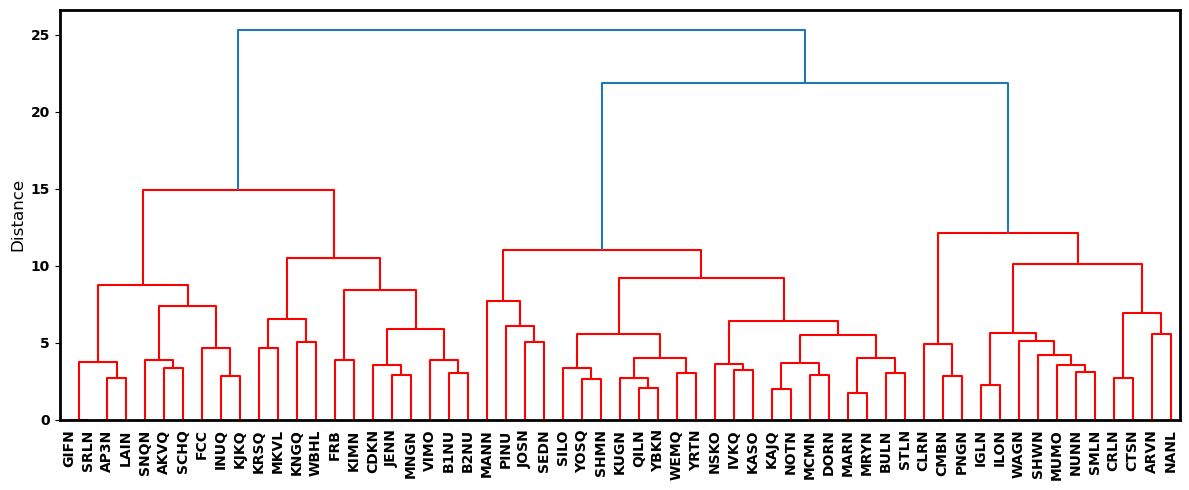

In [5]:
plot_dendrogram()

In [6]:
moho_depths = []
new_mod_Vs = vs_profiles
for i in range(len(new_mod_Vs)):
    moho_depths.append(np.array(depth)[new_mod_Vs[i] > 4][np.argmax(np.diff(new_mod_Vs[i][new_mod_Vs[i] > 4]))])
    
moho_depths = np.array(moho_depths)

In [7]:
amy_moho = pd.read_csv('PO_HB.moho', header=None, sep=' ').values[:,2]
amy_stns = pd.read_csv('PO_HB.moho', header=None, sep=' ').values[:,3]
amy_stns

array(['SRLN', 'LAIN', 'ILON', 'IGLN', 'AP3N', 'GIFN', 'MRYN', 'MARN',
       'PINU', 'CLRN', 'CMBN', 'PNGN', 'CDKN', 'JENN', 'FRB', 'MNGN',
       'B2NU', 'B1NU', 'KIMN', 'DORN', 'NOTN', 'MANN', 'CTSN', 'SHWN',
       'CRLN', 'SHMN', 'NUNN', 'WAGN', 'QILN', 'BULN', 'STLN', 'SMLN',
       'KUGN', 'YBKN', 'YRTN', 'JOSN', 'MCMN', 'SEDN', 'ARVN', 'FCC',
       'IVKQ', 'AKVQ', 'KNGQ', 'KRSQ', 'INUQ', 'SCHQ', 'KAJQ', 'NANL',
       'MKVL', 'NSKO', 'MUMO', 'KASO', 'SILO', 'VIMO', 'KJKQ', 'WEMQ',
       'YOSQ', 'WBHL', 'RES', 'EUNU', 'TULEG'], dtype=object)

In [8]:
for i in tqdm(range(len(amy_stns))):
    idx = np.where(np.array(stations) == amy_stns[i])[0][0]
    moho_depths[idx] = amy_moho[i]

 95%|█████████▌| 58/61 [00:00<00:00, 78297.27it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
VD = pd.read_csv(glob('acquired_data/*')[1], sep='\t')
vd = VD.drop([3,8])
vd = vd.replace('KRSQ(2)','KRSQ')
vd = vd.replace('SAKN(2)','SAKN')
vd.index = np.arange(9)

In [10]:
vd_stns = vd.values[:,0].astype('str')
vd_hlin = vd.values[:,1].astype('float')
vd_klin = vd.values[:,2].astype('float')

In [11]:
for i in tqdm(range(len(vd_stns))):
    try:
        idx = np.where(np.array(stations) == vd_stns[i])[0][0]
        moho_depths[idx] = vd_hlin[i]
        
    except:
        pass

100%|██████████| 9/9 [00:00<00:00, 43489.33it/s]


In [12]:
vd_stns

array(['KAJQ', 'KJKQ', 'KNGQ', 'KRSQ', 'KUQ', 'MKVL', 'NANL', 'SAKN',
       'WBHL'],
      dtype='<U4')

In [13]:
vd_hlin

array([ 37.1,  46.1,  48.6,  48. ,  46.1,  46.9,  33.1,  49. ,  47.8])

In [14]:
for i in range(len(stations)):
    if stations[i] not in amy_stns:
        print(stations[i])

SNQN


In [15]:
labels_ac  = cluster_profiles(quantity=np.array(vs_profiles), n_clusters=5, linkage='ward', d=[0,25], cluster='ac')

In [16]:
new_mod_Vs = np.array(new_mod_Vs)
stations = np.array(stations)

stn_lons = new_mod_lons[labels_ac == np.unique(labels_ac)[0]]
stn_lats = new_mod_lats[labels_ac == np.unique(labels_ac)[0]]
moho = moho_depths[labels_ac == np.unique(labels_ac)[0]]
l1 = new_mod_Vs[labels_ac == np.unique(labels_ac)[0]]
stn1 = stations[labels_ac == np.unique(labels_ac)[0]]


stn_lons1 = new_mod_lons[labels_ac == np.unique(labels_ac)[1]]
stn_lats1 = new_mod_lats[labels_ac == np.unique(labels_ac)[1]]
moho1 = moho_depths[labels_ac == np.unique(labels_ac)[1]]
l2 = new_mod_Vs[labels_ac == np.unique(labels_ac)[1]]
stn2 = stations[labels_ac == np.unique(labels_ac)[1]]

stn_lons2 = new_mod_lons[labels_ac == np.unique(labels_ac)[2]]
stn_lats2 = new_mod_lats[labels_ac == np.unique(labels_ac)[2]]
moho2 = moho_depths[labels_ac == np.unique(labels_ac)[2]]
l3 = new_mod_Vs[labels_ac == np.unique(labels_ac)[2]]
stn3 = stations[labels_ac == np.unique(labels_ac)[2]]

stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]
moho3 = moho_depths[labels_ac == np.unique(labels_ac)[3]]
l4 = new_mod_Vs[labels_ac == np.unique(labels_ac)[3]]
stn4 = stations[labels_ac == np.unique(labels_ac)[3]]


stn_lons4 = new_mod_lons[labels_ac == np.unique(labels_ac)[4]]
stn_lats4 = new_mod_lats[labels_ac == np.unique(labels_ac)[4]]
moho4 = moho_depths[labels_ac == np.unique(labels_ac)[4]]
l5 = new_mod_Vs[labels_ac == np.unique(labels_ac)[4]]
stn5 = stations[labels_ac == np.unique(labels_ac)[4]]

plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?
legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?


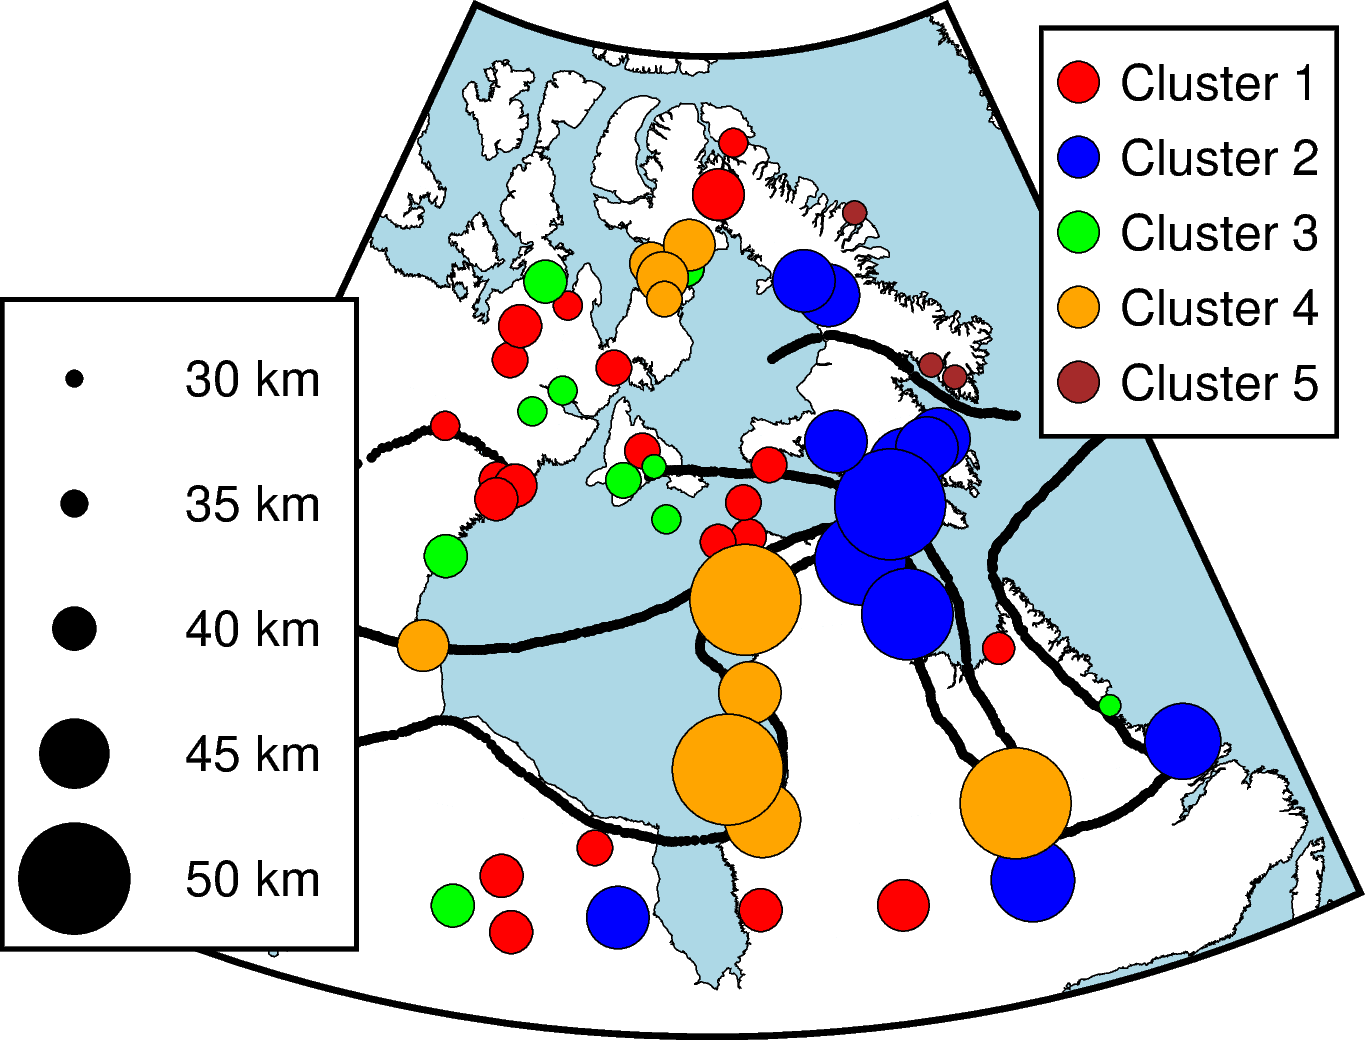

In [24]:
### PyGMT script
region=[-105,-55, 50, 75]
fig = pygmt.Figure()


pygmt.makecpt(cmap='geo',series='-4000/2000/250',continuous=True)

#topo_data = '@earth_relief_01m'

#fig.grdimage(grid=topo_data,region=region,projection='S-75/90/11c',cmap=True,shading=True)

pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_ANNOT_MIN_SPACING = 0.25)
fig.coast(area_thresh = 10000,
    projection='S-80/90/11c',
    region=region,
    shorelines=True,
    land = 'white',
    water = 'lightblue',
    resolution='i',
         frame=["wsne"])

fig.plot(x=fault1_lons,y=fault1_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault2_lons,y=fault2_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault3_lons,y=fault3_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault4_lons,y=fault4_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault5_lons,y=fault5_lats,style='c0.07c',color='black',pen='black',)


    
    

fig.plot(
    x=stn_lons,
    y=stn_lats,
    style='cc',
    color='red',
    pen='black',
    label='"Cluster 1"',
    sizes=0.008 * ((1.1)** moho)
)

fig.plot(
    x=stn_lons1,
    y=stn_lats1,
    style='cc',
    color='blue',
    pen='black',
    label='"Cluster 2"',
    sizes=0.008 * ((1.1)** moho1)
)


fig.plot(
    x=stn_lons2,
    y=stn_lats2,
    style='cc',
    color='green',
    pen='black',
    label='"Cluster 3"',
    sizes=0.008 * ((1.1)** moho2)
)


fig.plot(
    x=stn_lons3,
    y=stn_lats3,
    style='cc',
    color='orange',
    pen='black',
    label='"Cluster 4"',
    sizes=0.008 * ((1.1)** moho3)
)

fig.plot(
    x=stn_lons4,
    y=stn_lats4,
    style='cc',
    color='brown',
    pen='black',
    label='"Cluster 5"',
    sizes=0.008 * ((1.1)** moho4)
)


fig.plot(x=10,y=10,style='c0.35c',color='red',pen='black',label='"Cluster 1"')
fig.plot(x=11,y=10,style='c0.35c',color='blue',pen='black',label='"Cluster 2"')
fig.plot(x=12,y=10,style='c0.35c',color='green',pen='black',label='"Cluster 3"')
fig.plot(x=13,y=10,style='c0.35c',color='orange',pen='black',label='"Cluster 4"')
fig.plot(x=14,y=10,style='c0.35c',color='brown',pen='black',label='"Cluster 5"')



#fig.text(text=stntexts,y=stnlats+0.01,x=stnlons+0.07,font="6p,Helvetica-Bold,blue")
fig.legend(position = 'JTR+jTR+o0.2c+l1.5c', box='+gwhite+p1p', transparency=0)


#fig.plot(x=140,y=11,style='c'+str(0.008 * ((1.1)** 3))+'c',color='gray91',pen='gray91',label='"Moho Depth"')
#fig.legend(position='JBL+jTR+o-2.0c/-8c+w3c/4.5c+l2.5c',box='+ggray91+p1p', transparency=20)
fig.plot(x=140,y=10,style='c'+str(0.008 * ((1.1)** 30))+'c',color='black',pen='black',label='"30 km"')
fig.plot(x=141,y=10,style='c'+str(0.008 * ((1.1)** 35))+'c',color='black',pen='black',label='"35 km"')
fig.plot(x=142,y=10,style='c'+str(0.008 * ((1.1)** 40))+'c',color='black',pen='black',label='"40 km"')
fig.plot(x=143,y=10,style='c'+str(0.008 * ((1.1)** 45))+'c',color='black',pen='black',label='"45 km"')
fig.plot(x=144,y=10,style='c'+str(0.008 * ((1.1)** 50))+'c',color='black',pen='black',label='"50 km"')
fig.legend(position='JTL+jTR+o-2.5c/2.5c+w3c/5.5c+l2.5c',box='c0.1c/3c+gwhite+p1.1p',transparency=0)

fig.show()

In [45]:
np.nanstd(moho4)

0.0

In [35]:
np.max(moho4)

34

[None, None, None, None]

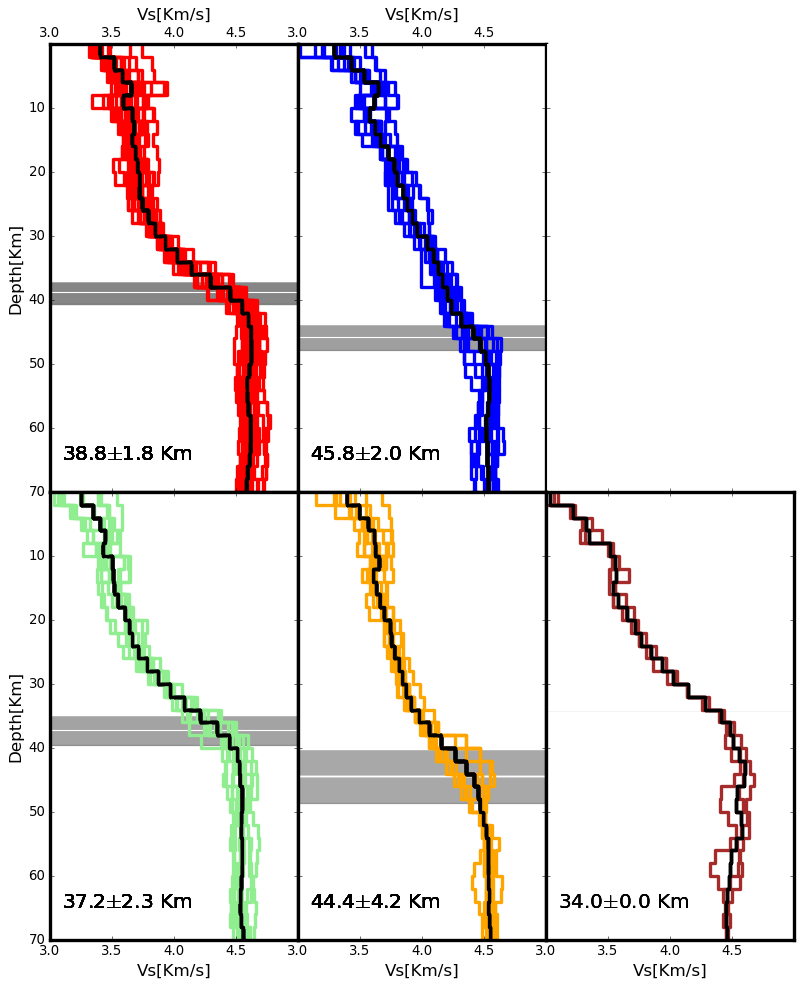

In [18]:
plt.style.use('classic')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12,14], sharex=True, sharey=True, facecolor= 'white')
plt.subplots_adjust(hspace=.0, wspace=0)

ax[0][0].axhline(np.around(np.mean(moho),1), lw=1, color='white')
for i in range(len(l1)):
    ax[0][0].step(x=l1[i],y=z[0],lw=3, color='red')
    ax[0][0].set_yticks([ 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[0][0].xaxis.set_tick_params(labeltop=True)
    ax[0][0].xaxis.set_label_position('top') 
    ax[0][0].set_xlabel('Vs[Km/s]', fontsize=15)
    ax[0][0].set_ylabel('Depth[Km]',fontsize=15)
    mean_val = np.mean(l1, axis=0)
    ax[0][0].step(x=mean_val,y=z[0],lw=3, color='black')
    ax[0][0].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho)+np.std(moho),y2=0,color='grey', alpha=0.1)
    ax[0][0].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho)-np.std(moho),y2=0,color='white', alpha=1.0)
    ax[0][0].text(3.1,65, str(np.around(np.mean(moho),1))+r'$ \pm $'+str(np.around(np.std(moho),1))+' Km', fontsize=18, fontweight='regular')

    
ax[0][1].axhline(np.around(np.mean(moho1),1), lw=1, color='white')    
for i in range(len(l2)):
    ax[0][1].step(x=l2[i],y=z[0],lw=3, color='blue')
    ax[0][1].set_xticks([3, 3.5, 4., 4.5])
    ax[0][1].set_yticks([ 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[0][1].xaxis.set_tick_params(labeltop=True)
    ax[0][1].xaxis.set_label_position('top') 
    ax[0][1].set_xlabel('Vs[Km/s]', fontsize=15)
    
    ax[0][1].set_ylim(100,0)
    ax[0][1].set_xlim(3,5)
    #ax[0][2].set_ylabel('Depth[Km]',fontsize=15)
    
    mean_val = np.mean(l2, axis=0)
    ax[0][1].step(x=mean_val,y=z[0],lw=3, color='black')
    ax[0][1].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho1)+np.std(moho1),y2=0,color='grey', alpha=0.1)
    ax[0][1].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho1)-np.std(moho1),y2=0,color='white', alpha=1.0) 
    ax[0][1].text(3.1,65, str(np.around(np.mean(moho1),1))+r'$ \pm $'+str(np.around(np.std(moho1),1))+' Km', fontsize=18, fontweight='regular')
    
right_side = ax[0][2].spines["right"]
right_side.set_visible(False)

right_side = ax[0][2].spines["top"]
right_side.set_visible(False)

ax[0][2].tick_params(right=False)
ax[0][2].tick_params(top=False)


ax[1][0].axhline(np.around(np.mean(moho2),1), lw=1, color='white')
for i in range(len(l3)):
    ax[1][0].step(x=l3[i],y=z[0],lw=3, color='lightgreen')
    ax[1][0].set_ylim(100,0)
    ax[1][0].set_xlim(3,5)
    ax[1][0].set_ylabel('Depth[Km]',fontsize=15)
    ax[1][0].set_xlabel('Vs[Km/s]', fontsize=15)
    ax[1][0].text(3.1,65, str(np.around(np.mean(moho2),1))+r'$ \pm $'+str(np.around(np.std(moho2),1))+' Km', fontsize=18, fontweight='regular')
    
    mean_val = np.mean(l3, axis=0)
    ax[1][0].step(x=mean_val,y=z[0],lw=3, color='black')
    ax[1][0].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho2)+np.std(moho2),y2=0,color='grey', alpha=0.1)
    ax[1][0].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho2)-np.std(moho2),y2=0,color='white', alpha=1.0)     
    
    ax[1][1].axhline(np.around(np.mean(moho3),1), lw=1, color='white')
for i in range(len(l4)):
    ax[1][1].step(x=l4[i],y=z[0],lw=3, color='orange')
    ax[1][1].set_ylim(100,0)
    ax[1][1].set_xticks([3, 3.5, 4., 4.5])
    ax[1][1].set_xlim(3,5)
    ax[1][1].set_xlabel('Vs[Km/s]', fontsize=15)
    #ax[1][1].set_ylabel('Depth[Km]',fontsize=15)
    ax[1][1].text(3.1,65, str(np.around(np.mean(moho3),1))+r'$ \pm $'+str(np.around(np.std(moho3),1))+' Km', fontsize=18, fontweight='regular')
    mean_val = np.mean(l4, axis=0)
    ax[1][1].step(x=mean_val,y=z[0],lw=3, color='black')
    ax[1][1].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho3)+np.std(moho3),y2=0,color='grey', alpha=0.1)
    ax[1][1].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho3)-np.std(moho3),y2=0,color='white', alpha=1.0)
    
    ax[1][2].axhline(np.around(np.mean(moho4),1), lw=1, color='white')
for i in range(len(l5)):
    ax[1][2].step(x=l5[i],y=z[0],lw=3, color='brown')
    ax[1][2].set_ylim(70,0)
    ax[1][2].set_xlim(3,5)
    ax[1][2].set_xlabel('Vs[Km/s]', fontsize=15)
    #ax[1][2].set_ylabel('Depth[Km]',fontsize=15)
    mean_val = np.mean(l5, axis=0)
    
    ax[1][2].step(x=mean_val,y=z[0],lw=3, color='black')
    ax[1][2].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho4)+np.std(moho4),y2=0,color='grey', alpha=0.5)
    ax[1][2].fill_between(x=np.linspace(2,5,100), y1=np.mean(moho4)-np.std(moho4),y2=0,color='white', alpha=1.0)  

    ax[1][2].text(3.1,65, str(np.around(np.mean(moho4),1))+r'$ \pm $'+str(np.around(np.std(moho4),1))+' Km', fontsize=18, fontweight='regular')
    
    
plt.setp(ax[0][0].spines.values(), linewidth=3)   
plt.setp(ax[0][1].spines.values(), linewidth=3) 
plt.setp(ax[1][0].spines.values(), linewidth=3) 
plt.setp(ax[1][1].spines.values(), linewidth=3) 
plt.setp(ax[1][2].spines.values(), linewidth=3)
#plt.tight_layout()

In [19]:
l = np.vstack([l1,l2,l3,l4,l5])
stn_corr = np.hstack([stn1,stn2,stn3,stn4,stn5])

In [20]:
corr = pd.DataFrame(np.corrcoef(l), columns=stn_corr)
corr.index = stn_corr

Text(126.0, 0.5, 'Stations')

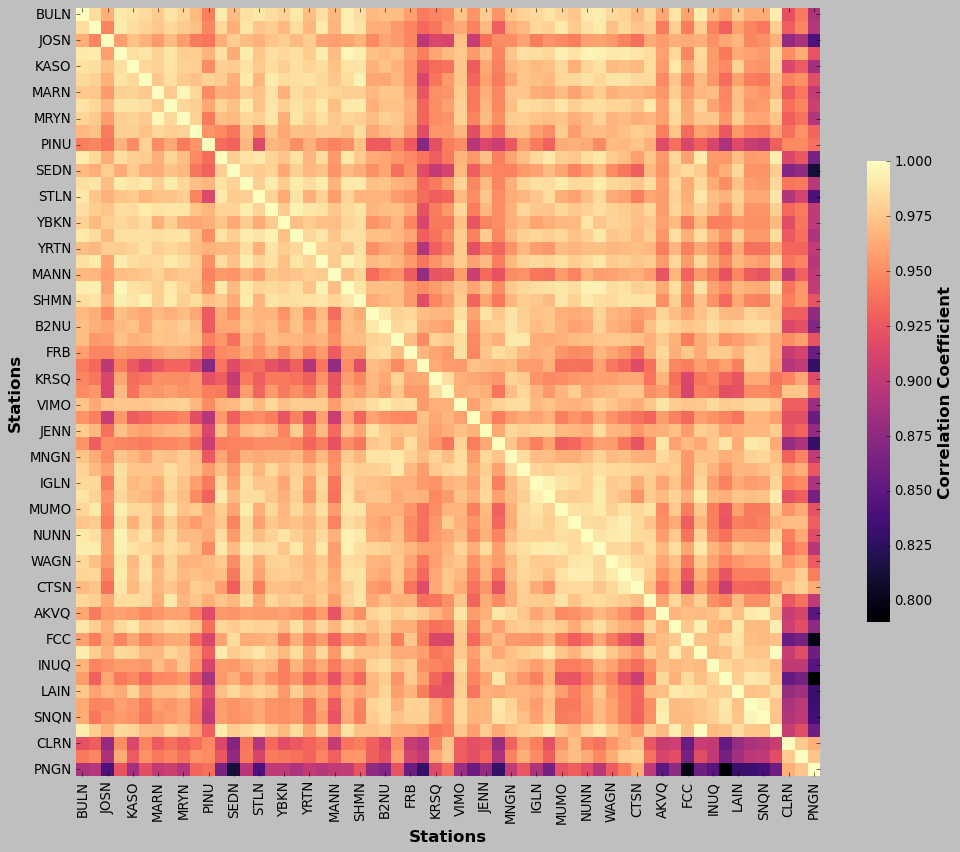

In [21]:
plt.figure(figsize=[15,12])
p1 = sns.heatmap(corr, cmap= 'magma', cbar_kws={'shrink': 0.6})
p1.collections[0].colorbar.set_label("Correlation Coefficient", fontweight = 'bold', fontsize=15, )
p1.set_xlabel('Stations', fontweight='bold', fontsize=15)
p1.set_ylabel('Stations', fontweight='bold', fontsize=15)

In [109]:
len(stn_corr)

59

In [110]:
stn1

array(['BULN', 'IVKQ', 'JOSN', 'KAJQ', 'KASO', 'KUGN', 'MARN', 'MCMN',
       'MRYN', 'NSKO', 'PINU', 'QILN', 'SEDN', 'SILO', 'STLN', 'WEMQ',
       'YBKN', 'YOSQ', 'YRTN', 'DORN', 'MANN', 'NOTN', 'SHMN'],
      dtype='<U4')

In [111]:
stn2

array(['B1NU', 'B2NU', 'CDKN', 'FRB', 'KNGQ', 'KRSQ', 'MKVL', 'VIMO',
       'WBHL', 'JENN', 'KIMN', 'MNGN'],
      dtype='<U4')

In [112]:
stn3

array(['ARVN', 'IGLN', 'ILON', 'MUMO', 'NANL', 'NUNN', 'SMLN', 'WAGN',
       'CRLN', 'CTSN', 'SHWN'],
      dtype='<U4')

In [113]:
stn4

array(['AKVQ', 'AP3N', 'FCC', 'GIFN', 'INUQ', 'KJKQ', 'LAIN', 'SCHQ',
       'SNQN', 'SRLN'],
      dtype='<U4')

In [50]:
df = pd.read_csv(glob('Robustness.csv')[0])
order = []
for i in range(len(stations)):
    order.append(np.where(df['Stations'].values==stations[i])[0][0])

new_mod_lats = df['Latitude'].values[order]
new_mod_lons = df['Longitude'].values[order]
labels_ac = df['Labels'].values[order]
percentages = df['Percentage'].values[order]*100

In [51]:
idx = np.where(df['Counts'] < 9)[0]
idx_lat = df['Latitude'][idx]
idx_lon = df['Longitude'][idx]
idx_p = df['Percentage'].values[order][idx]*100

In [52]:
stations[np.where(percentages < 70)[0]]

array(['AP3N', 'B2NU', 'GIFN', 'IGLN', 'ILON', 'KUGN', 'LAIN', 'NANL',
       'QILN', 'SILO', 'SMLN', 'SRLN', 'VIMO', 'SHMN'],
      dtype='<U4')

In [53]:
#labels_ac  = cluster_profiles(quantity=np.array(vs_profiles), n_clusters=5, linkage='ward', d=[0,25], cluster='ac')

stn_lons = new_mod_lons[labels_ac == np.unique(labels_ac)[0]]
stn_lats = new_mod_lats[labels_ac == np.unique(labels_ac)[0]]
p = percentages[labels_ac == np.unique(labels_ac)[0]]


stn_lons1 = new_mod_lons[labels_ac == np.unique(labels_ac)[1]]
stn_lats1 = new_mod_lats[labels_ac == np.unique(labels_ac)[1]]
p1 = percentages[labels_ac == np.unique(labels_ac)[1]]



stn_lons2 = new_mod_lons[labels_ac == np.unique(labels_ac)[2]]
stn_lats2 = new_mod_lats[labels_ac == np.unique(labels_ac)[2]]
p2 = percentages[labels_ac == np.unique(labels_ac)[2]]


stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]
p3 = percentages[labels_ac == np.unique(labels_ac)[3]]


stn_lons4 = new_mod_lons[labels_ac == np.unique(labels_ac)[4]]
stn_lats4 = new_mod_lats[labels_ac == np.unique(labels_ac)[4]]
p4 = percentages[labels_ac == np.unique(labels_ac)[4]]

plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +s<size> is used. Option -l ignored.
legend [WARNING]: Transparency is expected in percentage.  Did you mean 0?


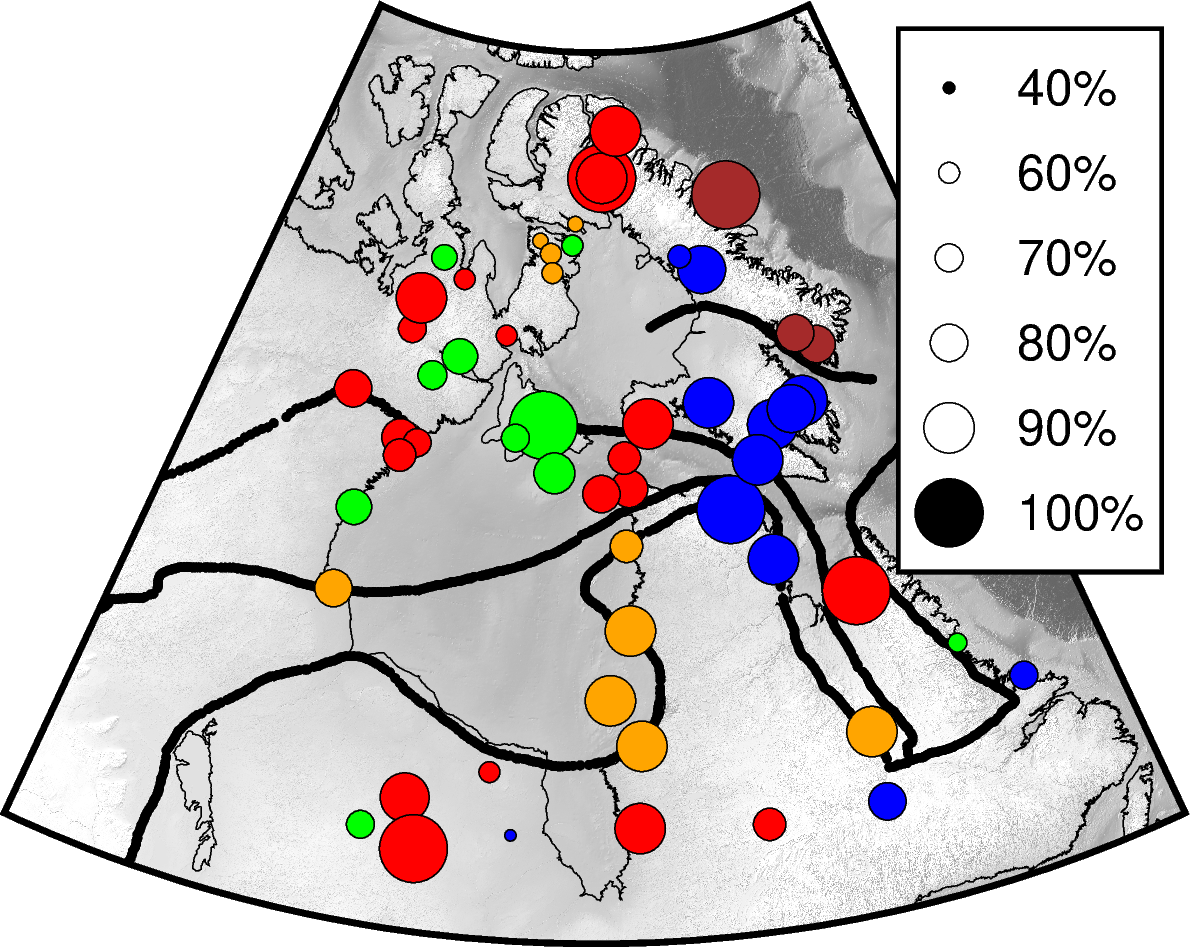

In [54]:
### PyGMT script
region=[-105,-55, 50, 75]
fig = pygmt.Figure()


pygmt.makecpt(cmap='etopo1',series='-10000/10000/1000',continuous=True)

#topo_data = '@earth_relief_01m'

#fig.grdimage(grid=topo_data,region=region,projection='S-75/90/7i',cmap='geo',shading=True,frame='a')

fig = pygmt.Figure()

pygmt.makecpt(cmap='gray',series='-1000/500/50',continuous=True)
topo_data = '@earth_relief_15s'
proj = 'S-80/90/10c'
fig.grdimage(grid=topo_data,region=region,projection=proj,cmap=True,shading=True,transparency=40)

#topo_data = '@earth_relief_01m'

#fig.grdimage(grid=topo_data,region=region,projection='S-75/90/7i',cmap='geo',shading=True,frame='a')

pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_ANNOT_MIN_SPACING = 0.25)

fig.coast(area_thresh = 10000,
    projection=proj,
    region=region,
    shorelines=True,
#    water="lightblue",
    resolution='i', frame=["wsne"],)

fig.plot(x=fault1_lons,y=fault1_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault2_lons,y=fault2_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault3_lons,y=fault3_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault4_lons,y=fault4_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault5_lons,y=fault5_lats,style='c0.07c',color='black',pen='black',)


   

base = 1.03
scale = 0.03

fig.plot(
    x=stn_lons,
    y=stn_lats,
    style='cc',
    color='red',
    label='"Cluster 1"',
    sizes=scale * ((base)** p),
    pen = "black"
)

fig.plot(
    x=stn_lons1,
    y=stn_lats1,
    style='cc',
    color='blue',
    pen='black',
    label='"Cluster 2"',
    sizes=scale * ((base)** p1)
)


fig.plot(
    x=stn_lons2,
    y=stn_lats2,
    style='cc',
    color='green',
    pen='black',
    label='"Cluster 3"',
    sizes=scale * ((base)** p2)
)


fig.plot(
    x=stn_lons3,
    y=stn_lats3,
    style='cc',
    color='orange',
    pen='black',
    label='"Cluster 4"',
    sizes=scale * ((base)** p3)
)

fig.plot(
    x=stn_lons4,
    y=stn_lats4,
    style='cc',
    color='brown',
    pen='black',
    label='"Cluster 5"',
    sizes=scale * ((base)** p4)
)




fig.plot(x=140,y=10,style='c'+str(scale * ((base)** 40))+'c',color='black',pen='black',label='"40%"')
fig.plot(x=141,y=10,style='c'+str(scale * ((base)** 60))+'c',color='white',pen='black',label='"60%"')
fig.plot(x=142,y=10,style='c'+str(scale * ((base)** 70))+'c',color='white',pen='black',label='"70%"')
fig.plot(x=143,y=10,style='c'+str(scale * ((base)** 80))+'c',color='white',pen='black',label='"80%"')
fig.plot(x=144,y=10,style='c'+str(scale * ((base)** 90))+'c',color='white',pen='black',label='"90%"')
fig.plot(x=145,y=10,style='c'+str(scale * ((base)** 100))+'c',color='black',pen='black',label='"100%"')
#fig.text(text=stntexts,y=stnlats+0.01,x=stnlons+0.07,font="6p,Helvetica-Bold,blue")
fig.legend(position = 'JTR+jTR+o0.2c+l1.7c', box='+gwhite+p1p', transparency=0)
fig.show()

In [60]:
print(np.nanmin(p3), np.nanmax(p3), np.nanmean(p3), np.nanstd(p3))

50.0 90.0 73.5 16.1322658049


[None, None, None, None]

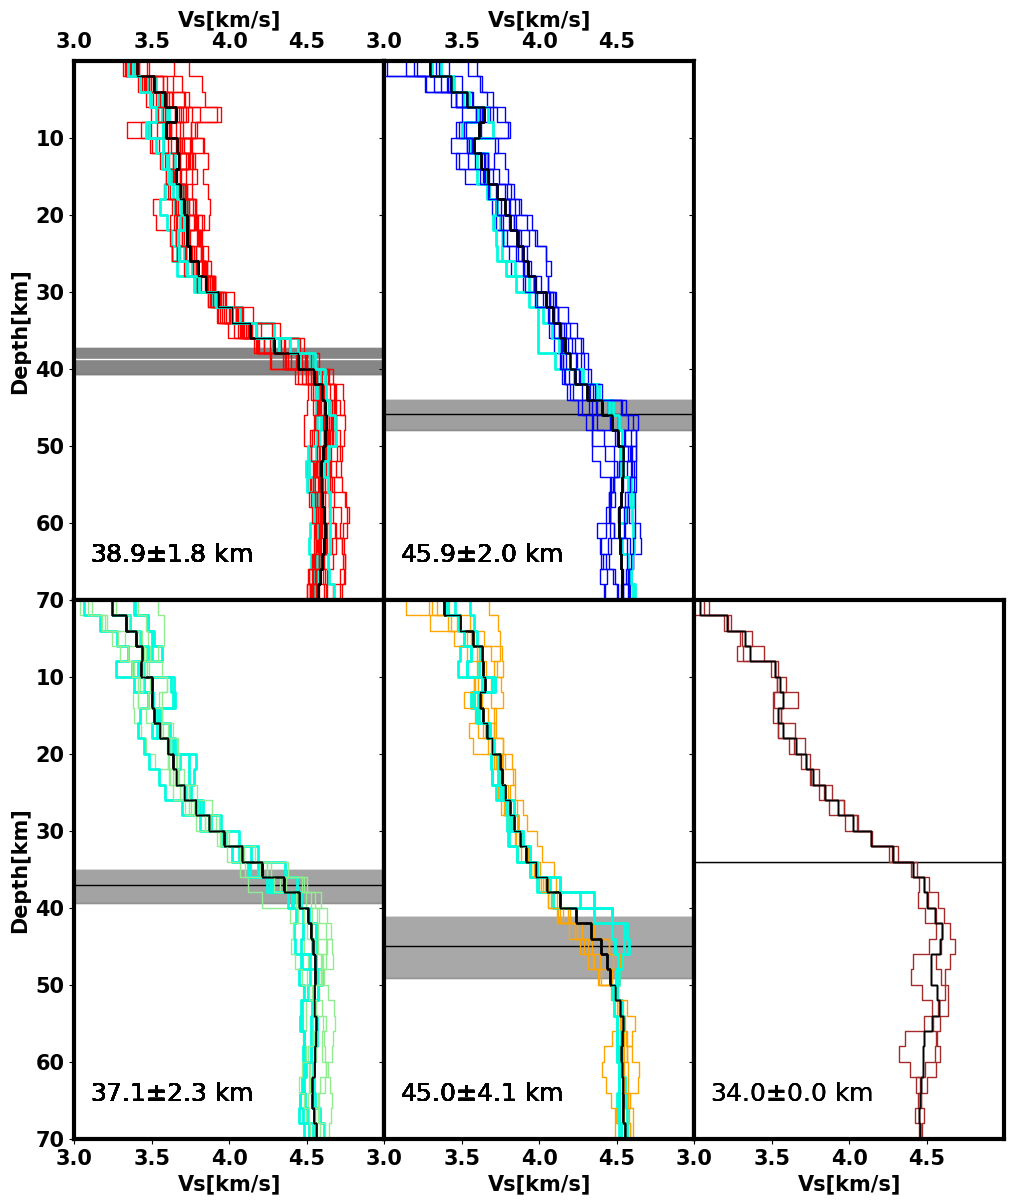

In [119]:
new_mod_Vs = np.array(new_mod_Vs)
import math
def w(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    weights = np.array(weights)
    average = np.dot(weights, values)/np.sum(weights)
    # Fast and numerically precise:
    variance = np.dot(weights,(values-average)**2)/np.sum(weights)
    return (average, (variance)**(0.5))




plt.style.use('dark_background')

stn_lons = new_mod_lons[labels_ac == np.unique(labels_ac)[0]]
stn_lats = new_mod_lats[labels_ac == np.unique(labels_ac)[0]]
l1 = new_mod_Vs[labels_ac == np.unique(labels_ac)[0]]


stn_lons1 = new_mod_lons[labels_ac == np.unique(labels_ac)[1]]
stn_lats1 = new_mod_lats[labels_ac == np.unique(labels_ac)[1]]
l2 = new_mod_Vs[labels_ac == np.unique(labels_ac)[1]]

stn_lons2 = new_mod_lons[labels_ac == np.unique(labels_ac)[2]]
stn_lats2 = new_mod_lats[labels_ac == np.unique(labels_ac)[2]]
l3 = new_mod_Vs[labels_ac == np.unique(labels_ac)[2]]

stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]
l4 = new_mod_Vs[labels_ac == np.unique(labels_ac)[3]]


stn_lons4 = new_mod_lons[labels_ac == np.unique(labels_ac)[4]]
stn_lats4 = new_mod_lats[labels_ac == np.unique(labels_ac)[4]]
l5 = new_mod_Vs[labels_ac == np.unique(labels_ac)[4]]


plt.style.use('default')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 15
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[12,14], sharex=True, sharey=True)
plt.subplots_adjust(hspace=.0, wspace=0)



lim = 70

ax[0][0].axhline(np.around(np.mean(moho),1), lw=1, color='white')
for i in range(len(l1)):
    if p[i] < lim:
        ax[0][0].step(x=l1[i],y=z[0],lw=2, color='#00fcdf', 
                      ms = 10,ls='-',markeredgecolor='black', label='<70%')
    else:
        ax[0][0].step(x=l1[i],y=z[0],lw=1, color='red', ls= '-')
    ax[0][0].set_yticks([ 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[0][0].xaxis.set_tick_params(labeltop=True)
    ax[0][0].xaxis.set_label_position('top') 
    ax[0][0].set_xlabel('Vs[km/s]', fontsize=15, fontweight='bold')
    ax[0][0].set_ylabel('Depth[km]',fontsize=15, fontweight='bold')
    mean_val = w(l1,p)[0]
    ax[0][0].step(x=mean_val,y=z[0],lw=1, color='black')
    ax[0][0].fill_between(x=np.linspace(2,5,100), y1=w(moho,p)[0]+w(moho,p)[1],y2=0,color='grey', alpha=0.1)
    ax[0][0].fill_between(x=np.linspace(2,5,100), y1=w(moho,p)[0]-w(moho,p)[1],y2=0,color='white', alpha=1.0)
    ax[0][0].text(3.1,65, str(np.around(w(moho,p)[0],1))+r'$ \pm $'+str(np.around(w(moho,p)[1],1))+' km', fontsize=18, fontweight='regular')



    
    
    

ax[0][1].axhline(np.around(w(moho1,p1)[0],1), lw=1, color='black')    
for i in range(len(l2)):
    if p1[i] < lim:
        ax[0][1].step(x=l2[i],y=z[0],lw=2, color='#00fcdf', ls= '-')
    else:
        ax[0][1].step(x=l2[i],y=z[0],lw=1, color='blue', ls= '-')    
    #ax[0][1].step(x=l2[i],y=z[0],lw=3, color='blue')
    ax[0][1].set_xticks([3, 3.5, 4., 4.5])
    ax[0][1].set_yticks([ 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[0][1].xaxis.set_tick_params(labeltop=True)
    ax[0][1].xaxis.set_label_position('top') 
    ax[0][1].set_xlabel('Vs[km/s]', fontsize=15, fontweight='bold')
    
    ax[0][1].set_ylim(100,0)
    ax[0][1].set_xlim(3,5)
    #ax[0][2].set_ylabel('Depth[Km]',fontsize=15)
    
    mean_val = w(l2,p1)[0]
    ax[0][1].step(x=mean_val,y=z[0],lw=1, color='black')
    ax[0][1].fill_between(x=np.linspace(2,5,100), y1=w(moho1,p1)[0]+w(moho1,p1)[1],y2=0,color='grey', alpha=0.1)
    ax[0][1].fill_between(x=np.linspace(2,5,100), y1=w(moho1,p1)[0]-w(moho1,p1)[1],y2=0,color='white', alpha=1.0) 
    ax[0][1].text(3.1,65, str(np.around(w(moho1,p1)[0],1))+r'$ \pm $'+str(np.around(w(moho1,p1)[1],1))+' km', fontsize=18, fontweight='regular')
    
right_side = ax[0][2].spines["right"]
right_side.set_visible(False)

right_side = ax[0][2].spines["top"]
right_side.set_visible(False)

ax[0][2].tick_params(right=False)
ax[0][2].tick_params(top=False)








ax[1][0].axhline(np.around(w(moho2,p2)[0],1), lw=1, color='black')
for i in range(len(l3)):
    if p2[i] < lim:
        ax[1][0].step(x=l3[i],y=z[0],lw=2, color='#00fcdf')
    else:
        ax[1][0].step(x=l3[i],y=z[0],lw=1, color='lightgreen') 
    ax[1][0].set_ylim(100,0)
    ax[1][0].set_xlim(3,5)
    ax[1][0].set_ylabel('Depth[km]',fontsize=15, fontweight='bold')
    ax[1][0].set_xlabel('Vs[km/s]', fontsize=15, fontweight='bold')
    ax[1][0].text(3.1,65, str(np.around(w(moho2,p2)[0],1))+r'$ \pm $'+str(np.around(w(moho2,p2)[1],1))+' km', fontsize=18, fontweight='regular')
    
    mean_val = w(l3,p2)[0]
    ax[1][0].step(x=mean_val,y=z[0],lw=1, color='black')
    ax[1][0].fill_between(x=np.linspace(2,5,100), y1=w(moho2,p2)[0]+w(moho2,p2)[1],y2=0,color='grey', alpha=0.1)
    ax[1][0].fill_between(x=np.linspace(2,5,100), y1=w(moho2,p2)[0]-w(moho2,p2)[1],y2=0,color='white', alpha=1.0)     
    

    
    

    
ax[1][1].axhline(np.around(w(moho3,p3)[0],1), lw=1, color='black')
for i in range(len(l4)):
    if p3[i] < lim:
        ax[1][1].step(x=l4[i],y=z[0],lw=2, color='#00fcdf')
    else:
        ax[1][1].step(x=l4[i],y=z[0],lw=1, color='orange')
    ax[1][1].set_ylim(100,0)
    ax[1][1].set_xticks([3, 3.5, 4., 4.5])
    ax[1][1].set_xlim(3,5)
    ax[1][1].set_xlabel('Vs[km/s]', fontsize=15, fontweight='bold')
    #ax[1][1].set_ylabel('Depth[Km]',fontsize=15)
    ax[1][1].text(3.1,65, str(np.around(w(moho3,p3)[0],1))+r'$ \pm $'+str(np.around(w(moho3,p3)[1],1))+' km', fontsize=18, fontweight='regular')
    mean_val = np.dot(p3,l4)/np.sum(p3)
    ax[1][1].step(x=mean_val,y=z[0],lw=1, color='black')
    ax[1][1].fill_between(x=np.linspace(2,5,100), y1=w(moho3,p3)[0]+w(moho3,p3)[1],y2=0,color='grey', alpha=0.1)
    ax[1][1].fill_between(x=np.linspace(2,5,100), y1=w(moho3,p3)[0]-w(moho3,p3)[1],y2=0,color='white', alpha=1.0)
    

    
    
    



    
    
    
ax[1][2].axhline(np.around(w(moho4,p4)[0],1), lw=1, color='black')
for i in range(len(l5)):
    if p4[i] <lim:
        ax[1][2].step(x=l5[i],y=z[0],lw=2, color='#00fcdf')
    else:
        ax[1][2].step(x=l5[i],y=z[0],lw=1, color='brown')
    ax[1][2].set_ylim(70,0)
    ax[1][2].set_xlim(3,5)
    ax[1][2].set_xlabel('Vs[km/s]', fontsize=15, fontweight='bold')
    #ax[1][2].set_ylabel('Depth[Km]',fontsize=15)
    mean_val = w(l5,p4)[0]
    
    ax[1][2].step(x=mean_val,y=z[0],lw=1, color='black')
    ax[1][2].fill_between(x=np.linspace(2,5,100), y1=w(moho4,p4)[0]+w(moho4,p4)[1],y2=0,color='grey', alpha=0.5)
    ax[1][2].fill_between(x=np.linspace(2,5,100), y1=w(moho4,p4)[0]-w(moho4,p4)[1],y2=0,color='white', alpha=1.0)  

    ax[1][2].text(3.1,65, str(np.around(w(moho4,p4)[0],1))+r'$ \pm $'+str(np.around(w(moho4,p4)[1],1))+' km', fontsize=18, fontweight='regular')
    
    
plt.setp(ax[0][0].spines.values(), linewidth=3)   
plt.setp(ax[0][1].spines.values(), linewidth=3) 
plt.setp(ax[1][0].spines.values(), linewidth=3) 
plt.setp(ax[1][1].spines.values(), linewidth=3) 
plt.setp(ax[1][2].spines.values(), linewidth=3)
#plt.tight_layout()

In [120]:
new_mod_stations = np.array(stations)
stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]
l4 = new_mod_Vs[labels_ac == np.unique(labels_ac)[3]]
stns = new_mod_stations[labels_ac == np.unique(labels_ac)[3]]

In [121]:
len(l4)

10

In [122]:
stns

array(['AKVQ', 'AP3N', 'FCC', 'GIFN', 'INUQ', 'KJKQ', 'LAIN', 'SCHQ',
       'SNQN', 'SRLN'],
      dtype='<U4')

Text(0.5, 0, 'Vs[km/s]')

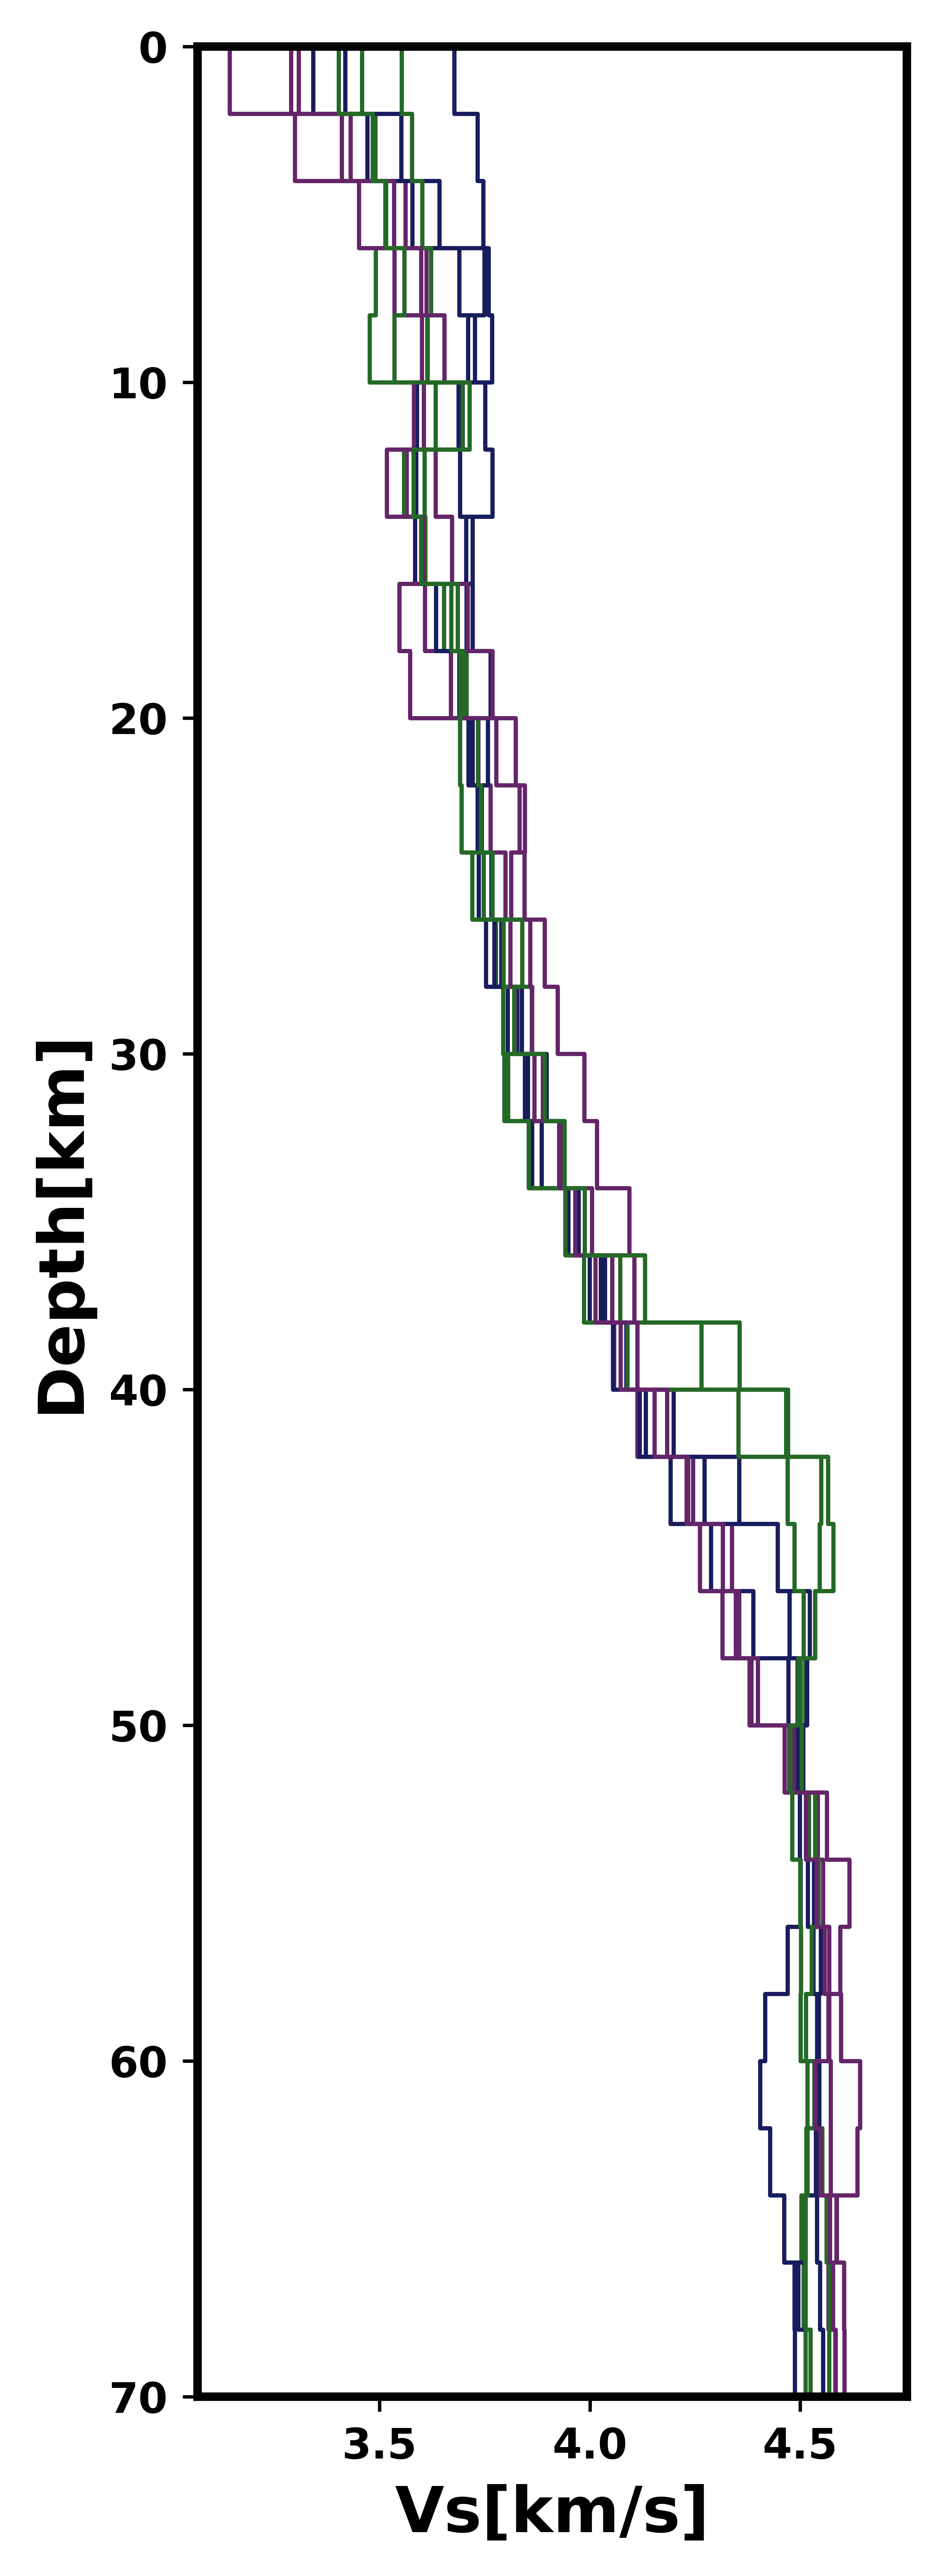

In [123]:
plt.style.use('default')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'
plt.figure(figsize=[3,10], dpi=800)
ls = ['#642569','#256927','#191d5e']
color = [ls[0], ls[1], ls[2], ls[1], ls[2],  ls[2],  ls[1], ls[0],ls[0],ls[1]]
for i in range(10): 
    plt.step(x=l4[i],y=z[0],lw=1, color=color[i])
plt.ylim(70,0)
plt.ylabel('Depth[km]',fontweight='bold', fontsize=15)
plt.xlabel('Vs[km/s]', fontweight='bold', fontsize=15)

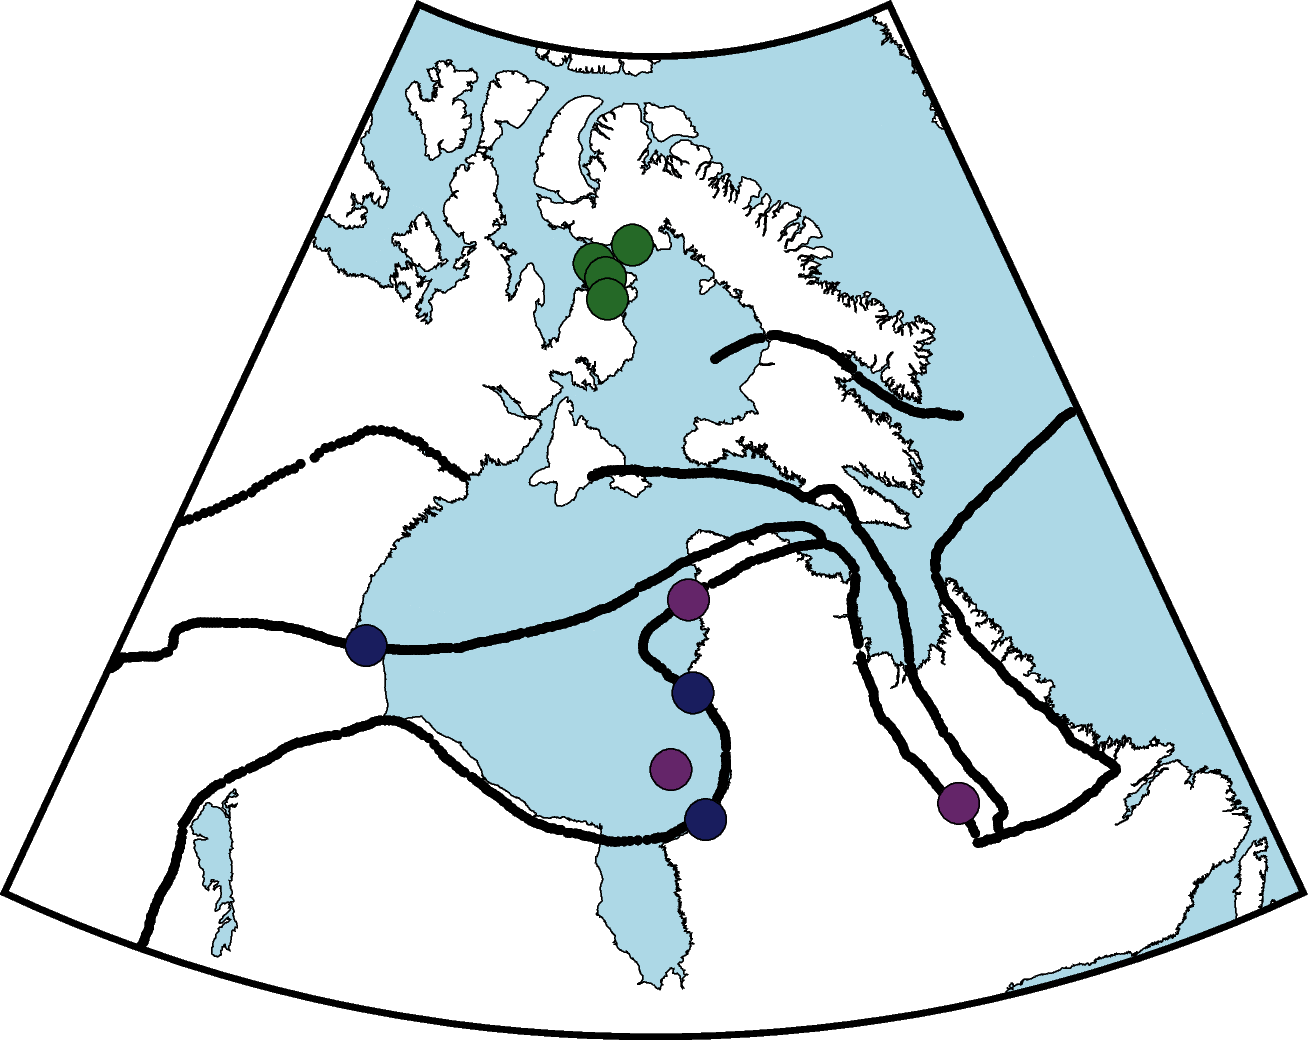

In [124]:
stn_lons = new_mod_lons[labels_ac == np.unique(labels_ac)[0]]
stn_lats = new_mod_lats[labels_ac == np.unique(labels_ac)[0]]

stn_lons1 = new_mod_lons[labels_ac == np.unique(labels_ac)[1]]
stn_lats1 = new_mod_lats[labels_ac == np.unique(labels_ac)[1]]

stn_lons2 = new_mod_lons[labels_ac == np.unique(labels_ac)[2]]
stn_lats2 = new_mod_lats[labels_ac == np.unique(labels_ac)[2]]

stn_lons3 = new_mod_lons[labels_ac == np.unique(labels_ac)[3]]
stn_lats3 = new_mod_lats[labels_ac == np.unique(labels_ac)[3]]


stn_lons4 = new_mod_lons[labels_ac == np.unique(labels_ac)[4]]
stn_lats4 = new_mod_lats[labels_ac == np.unique(labels_ac)[4]]


### PyGMT script
region=[-105,-55, 50, 75]
fig = pygmt.Figure()


pygmt.makecpt(cmap='etopo1',series='-10000/10000/1000',continuous=True)

#topo_data = '@earth_relief_01m'

#fig.grdimage(grid=topo_data,region=region,projection='S-75/90/7i',cmap='geo',shading=True,frame='a')

pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_ANNOT_MIN_SPACING = 0.25)
fig.coast(area_thresh = 10000,
    projection='S-80/90/11c',
    region=region,
    shorelines=True,
    water="lightblue",
    resolution='i',
         frame=["wsne"])

fig.plot(x=fault1_lons,y=fault1_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault2_lons,y=fault2_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault3_lons,y=fault3_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault4_lons,y=fault4_lats,style='c0.07c',color='black',pen='black',)
fig.plot(x=fault5_lons,y=fault5_lats,style='c0.07c',color='black',pen='black',)


    
    



for i in range(len(color)):
    fig.plot(
        x=stn_lons3[i],
        y=stn_lats3[i],
        style='c0.35c',
        color=color[i],
        pen='black'
    )




#fig.text(text=stntexts,y=stnlats+0.01,x=stnlons+0.07,font="6p,Helvetica-Bold,blue")
#fig.legend(position = 'JTR+jTR+o0.2c+l1.5c', box='+gwhite+p1p', transparency=0)
fig.show()

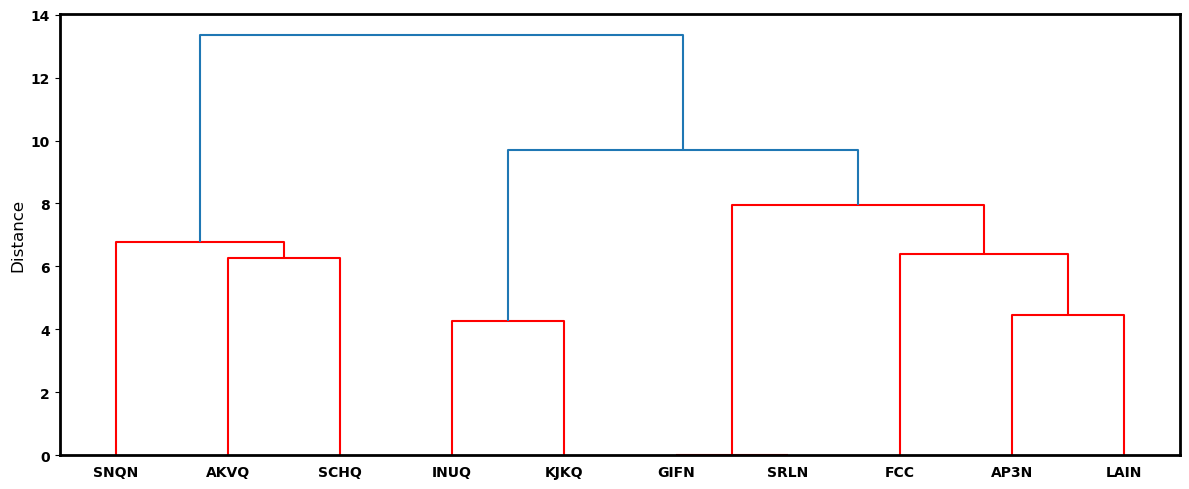

In [125]:
plot_dendrogram(quantity=np.array(l4),method='ward', stn_labels=stns, d=[0,25])